In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

df= pd.read_csv('cleaned_eco.csv')
df['pdata_clean']=df['pdata_clean'].astype(str)

def convertDate(d):
    new_date = datetime.strptime(d, "%Y-%m-%dT%H:%M:%S%z")
    return new_date.date()
 
df['published'] = df['published'].apply(lambda date: convertDate(date))
df


,file_name,page_number,title,summary,page_data,published,pdata_clean
0,paper_eco_1.pdf,1,The Link Between Standardization and Economic ...,We analyze the link between standardization ...,DOI: 10.4018/IJSR.287101International Journal ...,2022-01-22,internatnal journal standardizatresearvolume i...
1,paper_eco_1.pdf,2,The Link Between Standardization and Economic ...,We analyze the link between standardization ...,International Journal of Standardization Resea...,2022-01-22,internatnal journal standardizatresearvolume i...
2,paper_eco_1.pdf,3,The Link Between Standardization and Economic ...,We analyze the link between standardization ...,International Journal of Standardization Resea...,2022-01-22,internatnal journal standardizatresearvolume i...
3,paper_eco_1.pdf,4,The Link Between Standardization and Economic ...,We analyze the link between standardization ...,International Journal of Standardization Resea...,2022-01-22,internatnal journal standardizatresearvolume i...
4,paper_eco_1.pdf,5,The Link Between Standardization and Economic ...,We analyze the link between standardization ...,International Journal of Standardization Resea...,2022-01-22,internatnal journal standardizatresearvolume i...
...,...,...,...,...,...,...,...
661,paper_eco_19.pdf,19,The role of complex analysis in modeling econo...,Development and growth are complex and tumul...,49. World Bank Group. World Development Indica...,2018-08-30,world bank group world velopment indicators wa...
662,paper_eco_20.pdf,1,The Relationship between Consumption and Econo...,"Since Reform and Opening-up 40 years ago, Ch...",改革开放以来中国城乡居民消费与经济增长的关系\n——基于计量经济学模型的实证分析\n易志珩\...,2022-11-18,em articial intellence t relatnship beteconsum...
663,paper_eco_20.pdf,2,The Relationship between Consumption and Econo...,"Since Reform and Opening-up 40 years ago, Ch...",1引言（Introduction）\n消费对于国民经济发展有着重要的作用。改革开放40余年来...,2022-11-18,introduhousehold consumptand economic groh
664,paper_eco_20.pdf,3,The Relationship between Consumption and Econo...,"Since Reform and Opening-up 40 years ago, Ch...",3数据与模型（DataandModels）\n3.1变量的选择（SelectionofVar...,2022-11-18,data and mols seleof variablsource and process...


In [2]:
import pandas as pd
from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from gensim.models import LdaModel
import re

#function to preprocess text
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)  #non-alphabet characters removed
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words('english')]

    unigrams = words
    bigrams = [' '.join(phrase) for phrase in list(ngrams(words, 2))]
    
    return unigrams, bigrams  #return both unigrams and bigrams


#preprocessing of data
df['unigrams'], df['bigrams'] = zip(*df['pdata_clean'].apply(preprocess_text))

#dictionary for unigrams
dictionary_unigrams = corpora.Dictionary(df['unigrams'])
corpus_unigrams = [dictionary_unigrams.doc2bow(text) for text in df['unigrams']]

#train the LDA model for unigrams
lda_model_unigrams = LdaModel(corpus_unigrams, num_topics=10, id2word=dictionary_unigrams, passes=15)

#dictionary for bigrams
dictionary_bigrams = corpora.Dictionary(df['bigrams'])
corpus_bigrams = [dictionary_bigrams.doc2bow(text) for text in df['bigrams']]

#train the LDA model for bigrams
lda_model_bigrams = LdaModel(corpus_bigrams, num_topics=10, id2word=dictionary_bigrams, passes=15)

#function to get the most significant words for a topic
def get_topic_words(model, dictionary, topic):
    topic_words = [word for word, prob in model.show_topic(topic, topn=10) if word not in ['agents','agent','ai', 'intelligence','artificial intelligence','cial intelligence','artificial','arti cial','phys rev','phys',]]  # Adjust topn as needed
    return topic_words

#extract 3 unigram topics and 2 bigram topics
df['unigram_topics'] = df['unigrams'].apply(lambda x: get_topic_words(lda_model_unigrams, dictionary_unigrams, lda_model_unigrams[dictionary_unigrams.doc2bow(x)][0][0]))
df['bigram_topics'] = df['bigrams'].apply(lambda x: get_topic_words(lda_model_bigrams, dictionary_bigrams, lda_model_bigrams[dictionary_bigrams.doc2bow(x)][0][0]))

#combine the topics into a single column
df['topics'] = df.apply(lambda row: row['unigram_topics'][:3] + row['bigram_topics'][:2], axis=1)

df.to_csv('topics_eco_lda.csv', index=False)


In [3]:
df.drop(["page_number","title","summary", "page_data"], axis=1)


,file_name,published,pdata_clean,unigrams,bigrams,unigram_topics,bigram_topics,topics
0,paper_eco_1.pdf,2022-01-22,internatnal journal standardizatresearvolume i...,"[internatnal, journal, standardizatresearvolum...","[internatnal journal, journal standardizatrese...","[economics, intellence, articial, economic, jo...","[og lu, economic groh, cem og, journal economi...","[economics, intellence, articial, og lu, econo..."
1,paper_eco_1.pdf,2022-01-22,internatnal journal standardizatresearvolume i...,"[internatnal, journal, standardizatresearvolum...","[internatnal journal, journal standardizatrese...","[future, economic, table, economics, journal, ...","[og lu, economic groh, cem og, journal economi...","[future, economic, table, og lu, economic groh]"
2,paper_eco_1.pdf,2022-01-22,internatnal journal standardizatresearvolume i...,"[internatnal, journal, standardizatresearvolum...","[internatnal journal, journal standardizatrese...","[future, economic, table, economics, journal, ...","[og lu, economic groh, cem og, journal economi...","[future, economic, table, og lu, economic groh]"
3,paper_eco_1.pdf,2022-01-22,internatnal journal standardizatresearvolume i...,"[internatnal, journal, standardizatresearvolum...","[internatnal journal, journal standardizatrese...","[journal, economic, lu, groh, og, economics, c...","[ark boca, true ba, ari zac, est ari, articial...","[journal, economic, lu, ark boca, true ba]"
4,paper_eco_1.pdf,2022-01-22,internatnal journal standardizatresearvolume i...,"[internatnal, journal, standardizatresearvolum...","[internatnal journal, journal standardizatrese...","[journal, economic, lu, groh, og, economics, c...","[og lu, economic groh, cem og, journal economi...","[journal, economic, lu, og lu, economic groh]"
...,...,...,...,...,...,...,...,...
661,paper_eco_19.pdf,2018-08-30,world bank group world velopment indicators wa...,"[world, bank, group, world, velopment, indicat...","[world bank, bank group, group world, world ve...","[assets, revenue, intellence, articial, ark, a...","[ark boca, true ba, ari zac, est ari, articial...","[assets, revenue, intellence, ark boca, true ba]"
662,paper_eco_20.pdf,2022-11-18,em articial intellence t relatnship beteconsum...,"[em, articial, intellence, relatnship, betecon...","[em articial, articial intellence, intellence ...","[assets, revenue, intellence, articial, ark, a...","[assets assets, revenue assets, assets revenue...","[assets, revenue, intellence, assets assets, r..."
663,paper_eco_20.pdf,2022-11-18,introduhousehold consumptand economic groh,"[introduhousehold, consumptand, economic, groh]","[introduhousehold consumptand, consumptand eco...","[investment, mand, cost, interest, intellence,...","[ark boca, true ba, ari zac, est ari, articial...","[investment, mand, cost, ark boca, true ba]"
664,paper_eco_20.pdf,2022-11-18,data and mols seleof variablsource and process...,"[data, mols, seleof, variablsource, processi, ...","[data mols, mols seleof, seleof variablsource,...","[investment, mand, cost, interest, intellence,...","[ark boca, true ba, ari zac, est ari, articial...","[investment, mand, cost, ark boca, true ba]"


In [4]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_unigrams, corpus_unigrams, dictionary=dictionary_unigrams)
vis

c:\ProgramData\Anaconda3\envs\test_env\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\ProgramData\Anaconda3\envs\test_env\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\ProgramData\Anaconda3\envs\test_env\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\ProgramData\Anaconda3\envs\test_env\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
c:\ProgramData\Anaconda3\envs\test_env\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.234644 -0.091201       1        1  15.746973
8     -0.121152 -0.157613       2        1  13.311055
3     -0.101713 -0.069157       3        1  12.072558
7     -0.093280  0.118471       4        1  11.906496
2      0.179691  0.032478       5        1  10.608620
4     -0.023435 -0.068088       6        1   9.398021
0      0.070089  0.093306       7        1   8.133757
6     -0.060492  0.017113       8        1   7.973513
1     -0.056143  0.110877       9        1   6.565910
5     -0.028210  0.013814      10        1   4.283098, topic_info=             Term        Freq       Total Category  logprob  loglift
1610       assets  217.000000  217.000000  Default  30.0000  30.0000
1613        edits   84.000000   84.000000  Default  29.0000  29.0000
22        journal  184.000000  184.000000  Default  28.0000  28.0000
749    investment   64.000000   64.000000  Default  27.0000  27.0000
1232        loans   52.000000   52.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
1944          eur    2.171663   17.038160  Topic10  -5.8915   1.0905
495   maoeconomic    2.073939   33.741359  Topic10  -5.9375   0.3612
1942         belt    1.948217   24.180930  Topic10  -6.0000   0.6318
228         table    1.951392   78.932163  Topic10  -5.9984  -0.5496
1952         road    1.938377   34.275745  Topic10  -6.0051   0.2779

[638 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2149      9  0.787101  abruzzo
2645      1  0.745782      aci
2645      2  0.021935      aci
2645      6  0.153543      aci
2645      7  0.087739      aci
...     ...       ...      ...
2737      8  0.112801      zac
2737     10  0.056401      zac
343       2  0.745827       zi
343       3  0.082870       zi
343      10  0.082870       zi

[1321 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 9, 4, 8, 3, 5, 1, 7, 2, 6])

In [5]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_bigrams, corpus_bigrams, dictionary=dictionary_bigrams)
vis

c:\ProgramData\Anaconda3\envs\test_env\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\ProgramData\Anaconda3\envs\test_env\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\ProgramData\Anaconda3\envs\test_env\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
c:\ProgramData\Anaconda3\envs\test_env\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\ProgramData\Anaconda3\envs\test_env\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and wil

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.117118  0.087650       1        1  12.460118
4     -0.079265 -0.068145       2        1  12.036015
0      0.120401 -0.030325       3        1  12.021679
9      0.049267  0.175106       4        1  11.542307
6      0.017349 -0.045552       5        1  10.503702
2     -0.099160 -0.030163       6        1  10.250950
1      0.056166 -0.028871       7        1   9.254664
5      0.030898 -0.001999       8        1   9.110708
7      0.013577 -0.030656       9        1   6.778379
3      0.007885 -0.027045      10        1   6.041478, topic_info=                Term       Freq      Total Category  logprob  loglift
3205   assets assets  62.000000  62.000000  Default  30.0000  30.0000
5065  revenue assets  35.000000  35.000000  Default  29.0000  29.0000
5055  assets revenue  31.000000  31.000000  Default  28.0000  28.0000
93             og lu  28.000000  28.000000  Default  27.0000  27.0000
60            cem og  19.000000  19.000000  Default  26.0000  26.0000
...              ...        ...        ...      ...      ...      ...
6126        tenor og   1.456910   5.261924  Topic10  -6.5983   1.5223
6023      months ark   2.105601  41.366295  Topic10  -6.2300  -0.1713
6013        ark boca   1.151821  19.879649  Topic10  -6.8333  -0.0418
13     economic groh   0.992514  35.058235  Topic10  -6.9821  -0.7580
6688  intellence bei   0.988149   3.225216  Topic10  -6.9866   1.6236

[555 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
6925       9  0.660745  aci greete
6925      10  0.330373  aci greete
6881       4  0.968411    adr ante
6132       3  0.144012    agr meto
6132       5  0.576050    agr meto
...      ...       ...         ...
11520      3  0.957780      ys rev
6030      10  0.880236     zac est
7056       3  0.991583    zac regi
554        1  0.177813       zi li
554        4  0.711252       zi li

[895 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 5, 1, 10, 7, 3, 2, 6, 8, 4])

In [6]:
#LSA (Latent Semantic Analysis = finding top ten topics)

from sklearn.feature_extraction.text import CountVectorizer
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD

reindexed_data = df['pdata_clean']

small_count_vectorizer = CountVectorizer(stop_words='english', max_features=4000)
small_text_sample = reindexed_data.sample(n=500, random_state=0).values
small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

lsa_model = TruncatedSVD(n_components=10)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [7]:
from collections import Counter 

def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)


def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(10):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  economic journal economics groh table internatnal intellence articial lu og
Topic 2:  assets revenue equatns aregate investment tse usage economic nce continuity
Topic 3:  investment mand cost rate edits positive eq loans sis supply
Topic 4:  table simarly trefore mtable online basal distributn standardized dinary distributstroly
Topic 5:  ark months municips boca map alias regi intellence articial ba
Topic 6:  business risk tory nance nancial edit economic edits moody cye
Topic 7:  economic nero metro lucia tac sll journal tness le lexity
Topic 8:  north pa new worki technology coalab coameasurement management social analysis
Topic 9:  intellence articial ci aci la el ad ec eto li
Topic 10:  management mc rappi stunt eineeri adam review transans boost coe


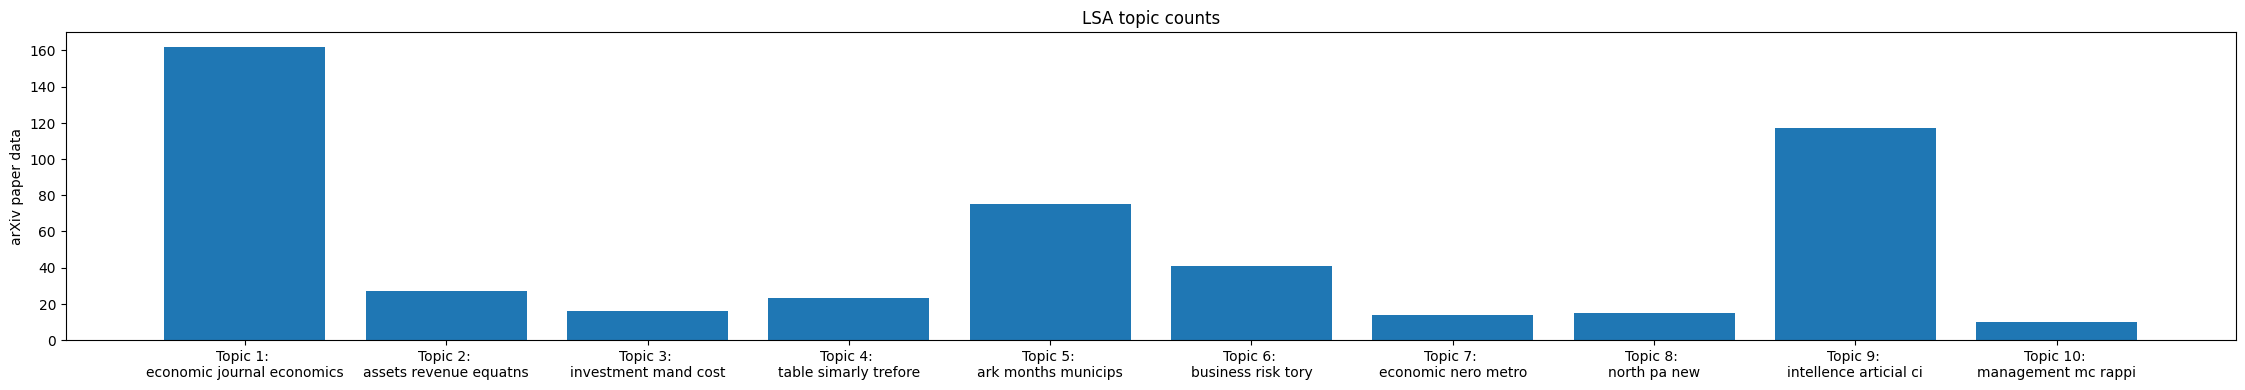

In [8]:
import matplotlib.pyplot as plt

top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i+1) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(28,4))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('arXiv paper data');
ax.set_title('LSA topic counts');
plt.show()


In [10]:
import warnings
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

# Suppress warnings
warnings.filterwarnings("ignore")

# Read the data from CSV
dfx = pd.read_csv('cleaned_eco.csv')
dfx['pdata_clean'] = dfx['pdata_clean'].astype(str)

# Drop unnecessary columns
dfx1 = dfx.drop(["page_data","summary","page_number","file_name","title"], axis=1)
#dfx1 = dfx1.dropna()

# Convert DataFrame to list of strings
docs = dfx1['pdata_clean'].values.tolist()

dfx1["length"] = dfx1["pdata_clean"].apply(lambda x : len(x.split()))

model = BERTopic(verbose=True,embedding_model='paraphrase-MiniLM-L3-v2', min_topic_size=7)
topics, _ = model.fit_transform(dfx1.pdata_clean)


2024-04-28 22:23:13,024 - BERTopic - Embedding - Transforming documents to embeddings.


KeyboardInterrupt: 

In [ ]:
#top 10 topics
model.get_topic_info().head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,161,-1_investment_rate_cost_it,"[investment, rate, cost, it, to, die, online, ...",[study that all study for so suboth eq summan...
1,0,52,0_journal_economic_economics_groh,"[journal, economic, economics, groh, og, lu, i...",[internatnal journal standardizatresearvolume ...
2,1,51,1_aci_ci_eto_la,"[aci, ci, eto, la, vida, ec, cci, cim, os, iform]",[antecent la inova ci plant meto problem inves...
3,2,38,2_municips_ark_months_map,"[municips, ark, months, map, municip, jo, ao, ...",[map a municips franci capita ene as gla uci l...
4,3,37,3_relatns_leotie_to_px,"[relatns, leotie, to, px, py, ined, trefore, a...",[ui ci precise ined to ui ci as seller ui ...
5,4,35,4_maoeconomic_business_economic_moody,"[maoeconomic, business, economic, moody, nance...",[ how mao transans sibe evolutfluuatnancial va...
6,5,33,5_wcw_next_abstra_aive,"[wcw, next, abstra, aive, velopi, notice, at, ...",[state velopi stl transitpublic velopi realizi...
7,6,30,6_intellence_articial_fall_wdle,"[intellence, articial, fall, wdle, key, hubs, ...","[e e articial intellence fall control, aug pe..."
8,7,27,7_coalab_coameasurement_worki_pa,"[coalab, coameasurement, worki, pa, new, north...",[coameasurement new coalab worki pa no table m...
9,8,25,8_table_dference_distributn_tests,"[table, dference, distributn, tests, standardi...","[table mtable standardized table distributn, t..."


In [ ]:
model.visualize_barchart(top_n_topics=9)

In [ ]:
model.visualize_term_rank()

In [ ]:
model.visualize_term_rank(log_scale=True)

In [ ]:
model.visualize_topics(top_n_topics=50)

In [ ]:
model.visualize_hierarchy(top_n_topics=50, width=800)

In [ ]:
model.visualize_heatmap(n_clusters=10, top_n_topics=20)

In [ ]:
timestamps = dfx1['published'].values.tolist()
topics_over_time = model.topics_over_time(docs, timestamps)
model.visualize_topics_over_time(topics_over_time, topics=[1,2,3,4,5,6,7,8,9,10])

0it [00:00, ?it/s]

20it [00:00, 67.26it/s]


In [ ]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from sklearn.feature_extraction.text import TfidfVectorizer

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

preprocess_docs = df['pdata_clean'].map(preprocess)


dictionary = gensim.corpora.Dictionary(preprocess_docs)

bow_corpus = [dictionary.doc2bow(doc) for doc in preprocess_docs]

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=10)

# Compute Perplexity
# measure of how good the model is. lower Perplexity the better.
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus)) 

# Compute Coherence Score
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=preprocess_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.133080731615399

Coherence Score:  0.4966308789860417


Setting Number of topics to: 4
Got coherence score of: 0.44984461479927235
Setting Number of topics to: 10
Got coherence score of: 0.5123924681273773
Setting Number of topics to: 16
Got coherence score of: 0.6028234540551358
Setting Number of topics to: 22
Got coherence score of: 0.6001901715170205
Setting Number of topics to: 28
Got coherence score of: 0.5809059362824411
Setting Number of topics to: 34
Got coherence score of: 0.5490401328675196


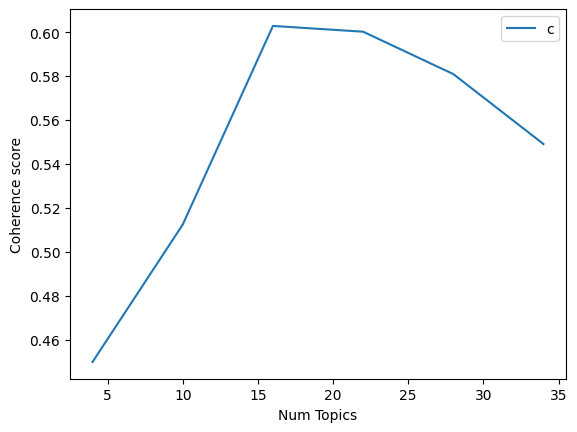

In [ ]:
# Compute Coherence Score
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    
    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    num_topics_list = []  # To store the corresponding num_topics
    for num_topics in range(start, limit, step):
        print('Setting Number of topics to:', num_topics)
        model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=2, workers=10)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherencemodel.get_coherence()
        coherence_values.append(coherence_score)
        num_topics_list.append(num_topics)  # Store the num_topics value
        print('Got coherence score of:', coherence_score)

    return num_topics_list, coherence_values  # Return both num_topics and coherence values

# Compute coherence values
result = compute_coherence_values(dictionary=dictionary, corpus=corpus_tfidf, texts=preprocess_docs, start=4, limit=40, step=6)

# Unpack result tuple
num_topics_list, coherence_values = result

# Plot coherence values
plt.plot(num_topics_list, coherence_values)  # Use num_topics_list as x-axis
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()